# builelibの出力JSONからグラフを作成

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates

## 計算結果を読み込む

In [2]:
js = open('builelib_data/builelib_result_AC.json', mode='r', encoding='utf-8')

In [3]:
dict = json.load(js)

In [4]:
js.close()

In [5]:
# 室負荷の読み込み[MJ/日]
room_load_c = np.array(dict['Qroom']['２F_事務室']['QroomDc'])
room_load_h = np.array(dict['Qroom']['２F_事務室']['QroomDh'])

# 外気負荷の読み込み[MJ/日]
vent_load = np.array(dict['AHU']['EHP1-1']['qoaAHU'])

# 装置負荷の読み込み（省エネ基準では空調負荷）[MJ/日]
ac_load_c = np.array(dict['AHU']['EHP1-1']['Qahu']['cooling_for_room'])
ac_load_h = np.array(dict['AHU']['EHP1-1']['Qahu']['heating_for_room'])

# 熱源負荷の読み込み[MJ/日]
ref_load_c = np.array(dict['REF']['EHP1-1O_冷房']['Qref'])
ref_load_h = - np.array(dict['REF']['EHP1-1O_暖房']['Qref'])

# 消費電力の読み込み[MWh/日]
ref_elec_c = np.array(dict['REF']['EHP1-1O_冷房']['E_ref_day_MWh'])
ref_elec_h = np.array(dict['REF']['EHP1-1O_暖房']['E_ref_day_MWh'])

# COPの計算
ref_cop_c = np.divide(ref_load_c / 3.6, (ref_elec_c * 1000.0), out=np.zeros(365), where=ref_elec_c > 0.0)
ref_cop_h = np.divide(-ref_load_h / 3.6, (ref_elec_h * 1000.0), out=np.zeros(365), where=ref_elec_h > 0.0)

In [6]:
# pandaにデータを読み込ませる
date_index_daily = pd.date_range(datetime(1989, 1, 1), datetime(1989, 12, 31), freq='D')
dd = pd.DataFrame(index=date_index_daily)
dd['room_load_c'] = room_load_c
dd['room_load_h'] = room_load_h
dd['vent_load'] = vent_load
dd['ac_load_c'] = ac_load_c
dd['ac_load_h'] = ac_load_h
dd['ref_load_c'] = ref_load_c
dd['ref_load_h'] = ref_load_h
dd['ref_elec_c'] = ref_elec_c
dd['ref_elec_h'] = ref_elec_h
dd['ref_cop_c'] = ref_cop_c
dd['ref_cop_h'] = ref_cop_h

#### ac_load_c_c:室負荷が冷房で装置負荷が冷房
#### ac_load_c_h:室負荷が冷房で装置負荷が暖房
#### ac_load_h_c:室負荷が暖房で装置負荷が冷房
#### ac_load_h_h:室負荷が暖房で装置負荷が暖房

In [7]:
# 月集計[GJ]
date_index_monthly = pd.date_range(datetime(1989, 1, 1), datetime(1989, 12, 31), freq='M')
dm = pd.DataFrame(index=date_index_monthly)
dm['room_load_c'] = dd['room_load_c'].resample('M').sum()
dm['room_load_h'] = dd['room_load_h'].resample('M').sum()
dm['vent_load_c'] = (dd[dd['vent_load'] > 0.0])['vent_load'].resample('M').sum()
dm['vent_load_h'] = (dd[dd['vent_load'] < 0.0])['vent_load'].resample('M').sum()
dm['ac_load_c_c'] = (dd[dd['ac_load_c'] > 0.0])['ac_load_c'].resample('M').sum()
dm['ac_load_c_h'] = (dd[dd['ac_load_c'] < 0.0])['ac_load_c'].resample('M').sum()
dm['ac_load_h_c'] = (dd[dd['ac_load_h'] > 0.0])['ac_load_h'].resample('M').sum()
dm['ac_load_h_h'] = (dd[dd['ac_load_h'] < 0.0])['ac_load_h'].resample('M').sum()
dm['ref_load_c'] = dd['ref_load_c'].resample('M').sum()
dm['ref_load_h'] = dd['ref_load_h'].resample('M').sum()
dm['ref_elec_c'] = dd['ref_elec_c'].resample('M').sum()
dm['ref_elec_h'] = dd['ref_elec_h'].resample('M').sum()

In [8]:
dd.to_csv('dd_output.csv', encoding='cp932')
dm.to_csv('dm_output.csv', encoding='cp932')

## 日積算室負荷のグラフ作成

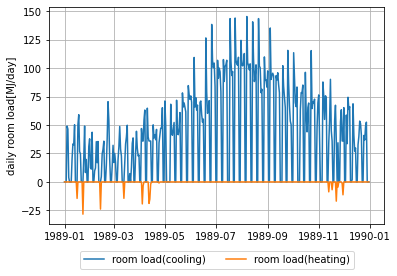

In [9]:
plt.plot(dd['room_load_c'], label='room load(cooling)')
plt.plot(dd['room_load_h'], label='room load(heating)')
plt.ylabel('daily room load[MJ/day]')

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

## 日積算外気負荷のグラフ

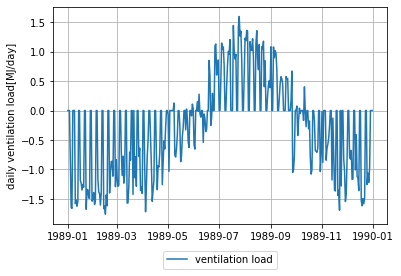

In [10]:
plt.plot(dd['vent_load'], label='ventilation load')
plt.ylabel('daily ventilation load[MJ/day]')

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

## 日積算装置負荷のグラフ
##### cooling:室負荷が正（冷房要求）であるときの空調負荷（正であれば冷却コイル負荷、負であれば加熱コイル負荷）[MJ/day]
##### heating:室負荷が負（暖房要求）であるときの空調負荷（正であれば冷却コイル負荷、負であれば加熱コイル負荷） [MJ/day]

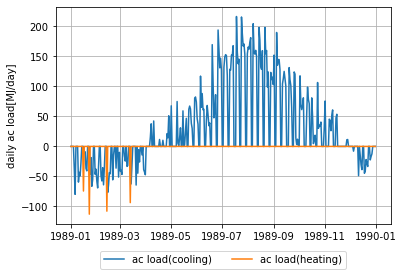

In [11]:
plt.plot(dd['ac_load_c'], label='ac load(cooling)')
plt.plot(dd['ac_load_h'], label='ac load(heating)')
plt.ylabel('daily ac load[MJ/day]')

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

## 日積算熱源負荷のグラフ

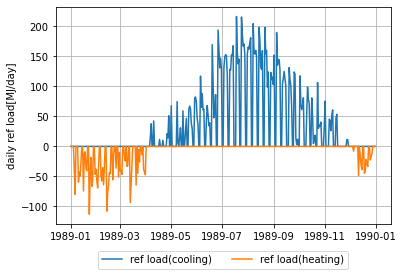

In [12]:
plt.plot(dd['ref_load_c'], label='ref load(cooling)')
plt.plot(dd['ref_load_h'], label='ref load(heating)')
plt.ylabel('daily ref load[MJ/day]')

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

## 日積算電力量

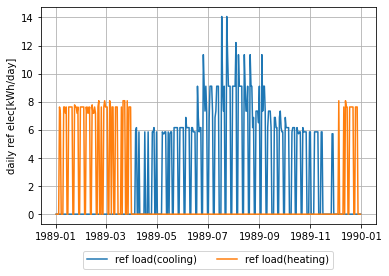

In [13]:
plt.plot(dd['ref_elec_c'] * 1000.0, label='ref load(cooling)')
plt.plot(dd['ref_elec_h'] * 1000.0, label='ref load(heating)')
plt.ylabel('daily ref elec[kWh/day]')

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

## 熱源負荷×日積算電力量

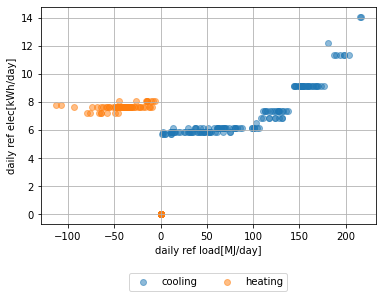

In [14]:
plt.scatter(x=dd['ref_load_c'], y=dd['ref_elec_c'] * 1000.0, alpha=0.5, label='cooling')
plt.scatter(x=dd['ref_load_h'], y=dd['ref_elec_h'] * 1000.0, alpha=0.5, label='heating')
plt.ylabel('daily ref elec[kWh/day]')
plt.xlabel('daily ref load[MJ/day]')

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()

## 熱源負荷×COP

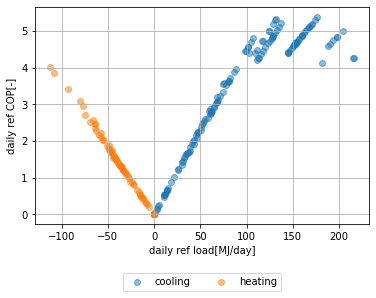

In [15]:
plt.scatter(x=dd['ref_load_c'], y=dd['ref_cop_c'], alpha=0.5, label='cooling')
plt.scatter(x=dd['ref_load_h'], y=dd['ref_cop_h'], alpha=0.5, label='heating')
plt.ylabel('daily ref COP[-]')
plt.xlabel('daily ref load[MJ/day]')

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()

## 月積算室負荷のグラフ

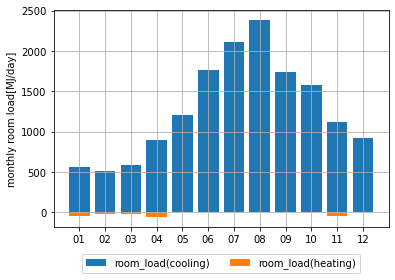

In [16]:
plt.bar(dm.index.strftime('%m'), dm['room_load_c'], label='room_load(cooling)')
plt.bar(dm.index.strftime('%m'), dm['room_load_h'], label='room_load(heating)')
plt.ylabel('monthly room load[MJ/day]')

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

## 月積算外気負荷のグラフ

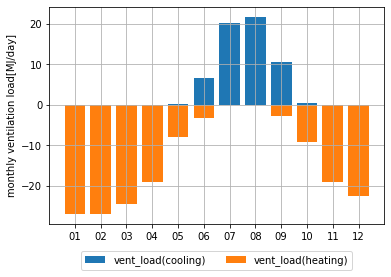

In [17]:
plt.bar(dm.index.strftime('%m'), dm['vent_load_c'], label='vent_load(cooling)')
plt.bar(dm.index.strftime('%m'), dm['vent_load_h'], label='vent_load(heating)')
plt.ylabel('monthly ventilation load[MJ/day]')

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

## 月積算装置負荷のグラフ

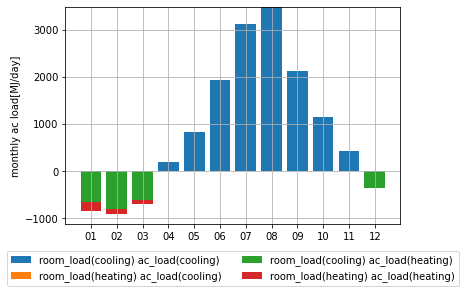

In [18]:
offsets = 0.0
plt.bar(dm.index.strftime('%m'), dm['ac_load_c_c'], bottom=offsets, label='room_load(cooling) ac_load(cooling)')
offsets += dm['ac_load_c_c']
plt.bar(dm.index.strftime('%m'), dm['ac_load_h_c'], bottom=offsets, label='room_load(heating) ac_load(cooling)')
offsets = 0.0
plt.bar(dm.index.strftime('%m'), dm['ac_load_c_h'], bottom=offsets, label='room_load(cooling) ac_load(heating)')
offsets += dm['ac_load_c_h']
plt.bar(dm.index.strftime('%m'), dm['ac_load_h_h'], bottom=offsets, label='room_load(heating) ac_load(heating)')
plt.ylabel('monthly ac load[MJ/day]')

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

## 月積算熱源負荷のグラフ

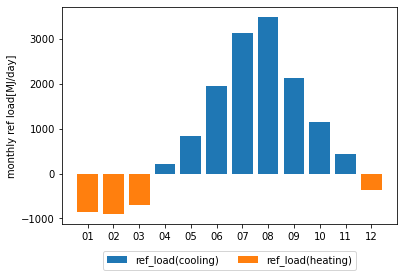

In [19]:
plt.bar(dm.index.strftime('%m'), dm['ref_load_c'], label='ref_load(cooling)')
plt.bar(dm.index.strftime('%m'), dm['ref_load_h'], label='ref_load(heating)')
plt.ylabel('monthly ref load[MJ/day]')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

## 月積算消費電力

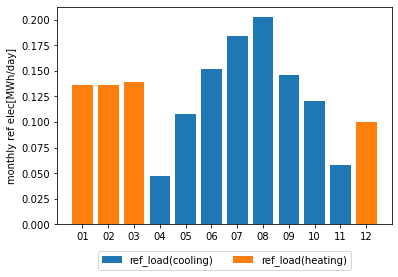

In [20]:
plt.bar(dm.index.strftime('%m'), dm['ref_elec_c'], label='ref_load(cooling)')
plt.bar(dm.index.strftime('%m'), dm['ref_elec_h'], label='ref_load(heating)')
plt.ylabel('monthly ref elec[MWh/day]')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

## 月平均COP

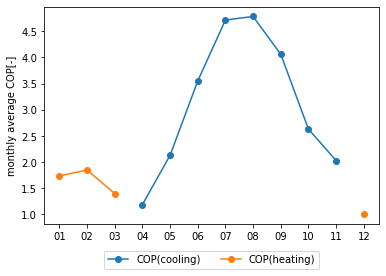

In [21]:
plt.plot(dm.index.strftime('%m'), 
        dm['ref_load_c'] / 3.6 / (dm['ref_elec_c'] * 1000.0), 
        label='COP(cooling)', marker='o')
plt.plot(dm.index.strftime('%m'), 
        -dm['ref_load_h'] / 3.6 / (dm['ref_elec_h'] * 1000.0), 
        label='COP(heating)', marker='o')
plt.ylabel('monthly average COP[-]')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

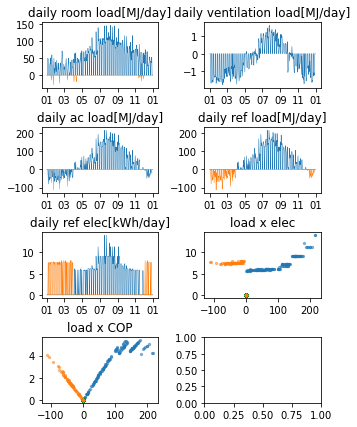

In [22]:
fig = plt.figure(figsize=(5, 7))
ax = fig.subplots(4, 2)
# 余白を設定
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# 室負荷
ax[0, 0].plot(dd['room_load_c'], label='cooling', linewidth = 0.5)
ax[0, 0].plot(dd['room_load_h'], label='heating', linewidth = 0.5)
ax[0, 0].set_title('daily room load[MJ/day]')
# 外気負荷
ax[0, 1].plot(dd['vent_load'], label='ventilation load', linewidth = 0.5)
ax[0, 1].set_title('daily ventilation load[MJ/day]')
# 装置負荷
ax[1, 0].plot(dd['ac_load_c'], label='ac load(cooling)', linewidth = 0.5)
ax[1, 0].plot(dd['ac_load_h'], label='ac load(heating)', linewidth = 0.5)
ax[1, 0].set_title('daily ac load[MJ/day]')

# 熱源負荷
ax[1, 1].plot(dd['ref_load_c'], label='ref load(cooling)', linewidth = 0.5)
ax[1, 1].plot(dd['ref_load_h'], label='ref load(heating)', linewidth = 0.5)
ax[1, 1].set_title('daily ref load[MJ/day]')

# 日積算電力
ax[2, 0].plot(dd['ref_elec_c'] * 1000.0, label='ref load(cooling)', linewidth = 0.5)
ax[2, 0].plot(dd['ref_elec_h'] * 1000.0, label='ref load(heating)', linewidth = 0.5)
ax[2, 0].set_title('daily ref elec[kWh/day]')

# 熱源負荷×電力量
ax[2, 1].scatter(x=dd['ref_load_c'], y=dd['ref_elec_c'] * 1000.0, alpha=0.5, label='cooling', s=5)
ax[2, 1].scatter(x=dd['ref_load_h'], y=dd['ref_elec_h'] * 1000.0, alpha=0.5, label='heating', s=5)
ax[2, 1].set_title('load x elec')

# 熱源負荷×COP
ax[3, 0].scatter(x=dd['ref_load_c'], y=dd['ref_cop_c'], alpha=0.5, label='cooling', s=5)
ax[3, 0].scatter(x=dd['ref_load_h'], y=dd['ref_cop_h'], alpha=0.5, label='heating', s=5)
ax[3, 0].set_title('load x COP')

# 室負荷のヒストグラム
#ax[3, 1].hist(x=dd['room_load_c'], histtype='step')
#ax[3, 1].hist(x=dd['room_load_h'], histtype='step')
#ax[3, 1].set_title('room load histgram')

plt.rcParams['font.size'] = 8

ax[0, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m'))

ax[0, 1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%m'))

ax[1, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m'))

ax[1, 1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%m'))

ax[2, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m'))

## 月積算値のグラフ

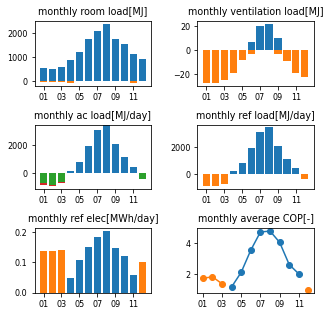

In [23]:
fig = plt.figure(figsize=(5, 5))
ax = fig.subplots(3, 2)
# 余白を設定
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# 月積算室負荷
ax[0, 0].bar(dm.index.strftime('%m'), dm['room_load_c'], label='room_load(cooling)')
ax[0, 0].bar(dm.index.strftime('%m'), dm['room_load_h'], label='room_load(heating)')
ax[0, 0].set_title('monthly room load[MJ]')

# 月積算外気負荷
ax[0, 1].bar(dm.index.strftime('%m'), dm['vent_load_c'], label='vent_load(cooling)')
ax[0, 1].bar(dm.index.strftime('%m'), dm['vent_load_h'], label='vent_load(heating)')
ax[0, 1].set_title('monthly ventilation load[MJ]')

# 月積算装置負荷
offsets = 0.0
ax[1, 0].bar(dm.index.strftime('%m'), dm['ac_load_c_c'], bottom=offsets, label='room_load(cooling) ac_load(cooling)')
offsets += dm['ac_load_c_c']
ax[1, 0].bar(dm.index.strftime('%m'), dm['ac_load_h_c'], bottom=offsets, label='room_load(heating) ac_load(cooling)')
offsets = 0.0
ax[1, 0].bar(dm.index.strftime('%m'), dm['ac_load_c_h'], bottom=offsets, label='room_load(cooling) ac_load(heating)')
offsets += dm['ac_load_c_h']
ax[1, 0].bar(dm.index.strftime('%m'), dm['ac_load_h_h'], bottom=offsets, label='room_load(heating) ac_load(heating)')
ax[1, 0].set_title('monthly ac load[MJ/day]')

# 月積算熱源負荷
ax[1, 1].bar(dm.index.strftime('%m'), dm['ref_load_c'], label='ref_load(cooling)')
ax[1, 1].bar(dm.index.strftime('%m'), dm['ref_load_h'], label='ref_load(heating)')
ax[1, 1].set_title('monthly ref load[MJ/day]')

# 月積算消費電力
ax[2, 0].bar(dm.index.strftime('%m'), dm['ref_elec_c'], label='ref_load(cooling)')
ax[2, 0].bar(dm.index.strftime('%m'), dm['ref_elec_h'], label='ref_load(heating)')
ax[2, 0].set_title('monthly ref elec[MWh/day]')

# 月平均COP
ax[2, 1].plot(dm.index.strftime('%m'), 
        dm['ref_load_c'] / 3.6 / (dm['ref_elec_c'] * 1000.0), 
        label='COP(cooling)', marker='o')
ax[2, 1].plot(dm.index.strftime('%m'), 
        -dm['ref_load_h'] / 3.6 / (dm['ref_elec_h'] * 1000.0), 
        label='COP(heating)', marker='o')
ax[2, 1].set_title('monthly average COP[-]')

plt.rcParams['font.size'] = 8

for i in range(3):
    for j in range(2):
        ax[i, j].xaxis.set_major_locator(plt.MultipleLocator(2))

## 年間エネルギー消費量のグラフ

In [24]:
js = open('builelib_data/builelib_result.json', mode='r', encoding='utf-8')
dict = json.load(js)
js.close()

energy_AC = np.array([dict['設計一次エネルギー消費量（空調） [MJ]'] / 1000.0, dict['基準一次エネルギー消費量（空調） [MJ]'] / 1000.0])
energy_light = np.array([dict['設計一次エネルギー消費量（照明） [MJ]'] / 1000.0, dict['基準一次エネルギー消費量（照明） [MJ]'] / 1000.0])
label = []
label.append('design')
label.append('base')

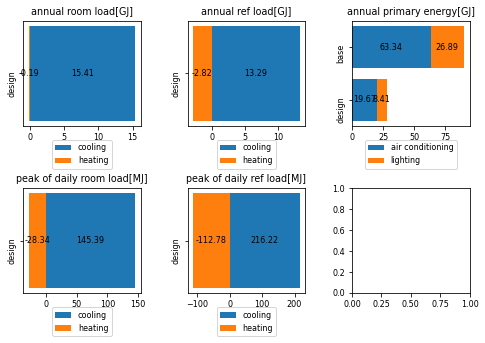

In [25]:
fig = plt.figure(figsize=(8, 5))
ax = fig.subplots(2, 3)
# 余白を設定
plt.subplots_adjust(wspace=0.4, hspace=0.6)

room_load_c = np.array([dm['room_load_c'].sum() / 1000.0])
room_load_h = np.array([dm['room_load_h'].sum() / 1000.0])
xlabel = np.array(['design'])

# 年積算室負荷
ax[0, 0].barh(xlabel, room_load_c, label='cooling')
ax[0, 0].barh(xlabel, room_load_h, label='heating')
ax[0, 0].set_title('annual room load[GJ]')
ax[0, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
ax[0, 0].text(x=room_load_c[0] / 2, y=0, s=round(room_load_c[0], 2), ha='center', va='center')
ax[0, 0].text(x=room_load_h[0] / 2, y=0, s=round(room_load_h[0], 2), ha='center', va='center')
ax[0, 0].tick_params(axis='y', rotation=90)

# 年積算エネルギー
offsets = 0.0
ax[0, 2].barh(label, energy_AC, left=offsets, label='air conditioning')
for AC in range(2):
    ax[0, 2].text(x=energy_AC[AC] / 2, y=AC, s=round(energy_AC[AC], 2), ha='center', va='center')
offsets += energy_AC
ax[0, 2].barh(label, energy_light, left=offsets, label='lighting')
ax[0, 2].set_title('annual primary energy[GJ]')
ax[0, 2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
ax[0, 2].tick_params(axis='y', rotation=90)
for light in range(2):
    x = energy_light[light] / 2 + offsets[light]
    ax[0, 2].text(x=x, y=light, s=round(energy_light[light], 2), ha='center', va='center')

# 年積算熱源負荷
ref_load_c = np.array([dm['ref_load_c'].sum() / 1000.0])
ref_load_h = np.array([dm['ref_load_h'].sum() / 1000.0])
ax[0, 1].barh(xlabel, ref_load_c, label='cooling')
ax[0, 1].barh(xlabel, ref_load_h, label='heating')
ax[0, 1].set_title('annual ref load[GJ]')
ax[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
ax[0, 1].text(x=ref_load_c[0] / 2, y=0, s=round(ref_load_c[0], 2), ha='center', va='center')
ax[0, 1].text(x=ref_load_h[0] / 2, y=0, s=round(ref_load_h[0], 2), ha='center', va='center')
ax[0, 1].tick_params(axis='y', rotation=90)

# 日積算最大室負荷
room_peak_load_c = dd['room_load_c'].max()
room_peak_load_h = dd['room_load_h'].min()
ax[1, 0].barh(xlabel, room_peak_load_c, label='cooling')
ax[1, 0].barh(xlabel, room_peak_load_h, label='heating')
ax[1, 0].set_title('peak of daily room load[MJ]')
ax[1, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
ax[1, 0].text(x=room_peak_load_c / 2, y=0, s=round(room_peak_load_c, 2), ha='center', va='center')
ax[1, 0].text(x=room_peak_load_h / 2, y=0, s=round(room_peak_load_h, 2), ha='center', va='center')
ax[1, 0].tick_params(axis='y', rotation=90)

# 日積算最大熱源負荷
ref_peak_load_c = dd['ref_load_c'].max()
ref_peak_load_h = dd['ref_load_h'].min()
ax[1, 1].barh(xlabel, ref_peak_load_c, label='cooling')
ax[1, 1].barh(xlabel, ref_peak_load_h, label='heating')
ax[1, 1].set_title('peak of daily ref load[MJ]')
ax[1, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
ax[1, 1].text(x=ref_peak_load_c / 2, y=0, s=round(ref_peak_load_c, 2), ha='center', va='center')
ax[1, 1].text(x=ref_peak_load_h / 2, y=0, s=round(ref_peak_load_h, 2), ha='center', va='center')
ax[1, 1].tick_params(axis='y', rotation=90)

plt.show()